<a href="https://colab.research.google.com/github/IgorShestov/pet-projects/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22stop_the_s_toxic_comments_eda_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/andrewkalita/nlp-toxic-detection-russian-comments

https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda#Baseline-Model:

https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge

https://boosters.pro/championships


https://cups.mail.ru/ru/contests/?category=ml

# Update: 
The kernal has been updated for the new test and train datasets.

# Introduction:
Being anonymous over the internet can sometimes make people say nasty things that they normally would not in real life.
Let's filter out the hate from our platforms one comment at a time. 

## Objective:
To create an EDA/ feature-engineering starter notebook for toxic comment classification.

## Data Overview:
The dataset here is from wiki corpus dataset which was rated by human raters for toxicity.
The corpus contains 63M comments from discussions relating to user pages and articles dating from 2004-2015. 

Different platforms/sites can have different standards for their toxic screening process. Hence the comments are tagged in the following five categories
* toxic
* severe_toxic
* obscene
* threat
* insult
* identity_hate

The tagging was done via **crowdsourcing** which means that the dataset was rated by different people and the tagging might not be 100% accurate too. The same concern is being discussed [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/46131).

The [source paper](https://arxiv.org/pdf/1610.08914.pdf) also contains more interesting details about the dataset creation.

## Note:
A [New test dataset](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/46177) is being created by the organizers as the test set labels are present [here](https://figshare.com/articles/Wikipedia_Talk_Labels_Toxicity/4563973).

The kernal has been updated for the new data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Check the dataset sizes(in MB)
!du -l ../input/*

du: cannot access '../input/*': No such file or directory


In [ ]:
pip install scipy==1.1.0

In [ ]:
pip install Pillow

In [ ]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
from scipy import sparse
#from scipy.misc import imread
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
stopwords = set(stopwords.words('russian') )
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#importing the dataset
train= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DF/Bad_comment/train.txt', sep='\t', error_bad_lines=False,  names = ["id", "label", "comment"])
test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DF/Bad_comment/data.txt', sep='\t', error_bad_lines=False,  names = ["id", "comment"])

**Текст, выделенный полужирным шрифтом**
### Class Imbalance:

In [ ]:
#take a sample
train.sample(10)

,id,label,comment
136606,156427,__label__NORMAL,"какие красивые ! обалдеть ! супер ! удачи , сч..."
52076,8868,__label__NORMAL,лично звонил вчера на вокзал г. ровеньки. ходи...
114213,232484,__label__NORMAL,я с вами согласна.дорого.
20695,93626,__label__NORMAL,"настоящая русская красавица,талантливая,певица..."
70770,161403,__label__NORMAL,ну не всем подойдет ее способ похудения 🤔
112540,222968,__label__NORMAL,легкой недели желаю gтастья вот все и
48605,33665,__label__NORMAL,а детям будут платить за риск заразиться или з...
139311,42761,__label__NORMAL,все хорошо. только как крем готовить?
90305,145482,__label__NORMAL,"друзья мои верные, выручайте в трудном деле! д..."
73415,2289,__label__NORMAL,"каждый видел то что хотел и я видел, то о чём ..."


In [ ]:
test.sample(10)

,id,comment
240095,73678,"галя,впереди,через два дня входные,так что не ..."
87667,13087,"на первом кольце,голубой камешек большой белый..."
205321,4033,а что грустим?
82272,43517,а ты судя по коментам обычный диванный обоссан...
98328,211327,просто так они не приезжают.значет причина была!
189436,243445,это так 😉
187183,23739,"ты дура ,это совсем видеоролик ,не о том .ты ч..."
74813,243994,хорошая машина а еще зил 131 на самом деле их ...
199600,140072,интересно сколько лет надо ждать что бы это пр...
240679,192464,не нагоняйте тоску


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148775 entries, 0 to 148774
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       148775 non-null  int64 
 1   label    148775 non-null  object
 2   comment  148775 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.4+ MB


In [ ]:
train.label.value_counts()

__label__NORMAL       122194
__label__INSULT        21952
__label__THREAT         3263
__label__OBSCENITY      1366
Name: label, dtype: int64

The data has 1 column with labels. let's create 4 and change their labels from 0 to 1

In [ ]:
train['normal']=train['label']
train['insult']=train['label']
train['threat']=train['label']
train['obscenity']=train['label']

In [ ]:
n = {'__label__NORMAL':1,'__label__INSULT':0,'__label__THREAT':0, '__label__OBSCENITY':0}
i = {'__label__NORMAL':0,'__label__INSULT':1,'__label__THREAT':0, '__label__OBSCENITY':0}
t = {'__label__NORMAL':0,'__label__INSULT':0,'__label__THREAT':1, '__label__OBSCENITY':0}
o = {'__label__NORMAL':0,'__label__INSULT':0,'__label__THREAT':0, '__label__OBSCENITY':1}

In [ ]:
train['normal']=train['normal'].replace(n)

In [ ]:
train['insult']=train['insult'].replace(i)

In [ ]:
train['threat']=train['threat'].replace(t)

In [ ]:
train['obscenity']=train['obscenity'].replace(o)

In [ ]:
train.drop(columns='label', inplace=True)

In [ ]:
train.head()

,id,comment,normal,insult,threat,obscenity
0,41127,дворника надо тоже уничтожить!,0,0,1,0
1,6812,"моя старшая неделю шипела, не принимала подкид...",1,0,0,0
2,6256,полностью с вами согласна!,1,0,0,0
3,189636,"хоть ногу вверх, ничего не изменится",1,0,0,0
4,99053,а что значит - левого ребенка?,1,0,0,0


In [ ]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("          : train : test")
print("строки    :",nrow_train,":",nrow_test)
print("процент   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

          : train : test
строки    : 148775 : 248290
процент   : 37    : 63


There is a 37:63 train: test split and the test set might change in the future too.

Let's take a look at the class imbalance in the train set.

In [ ]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  148775
Total clean comments =  0
Total tags = 148775


In [ ]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment"].fillna("unknown", inplace=True)
test["comment"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id           0
comment      0
normal       0
insult       0
threat       0
obscenity    0
clean        0
dtype: int64
Check for missing values in Test dataset
id         0
comment    0
dtype: int64
filling NA with "unknown"


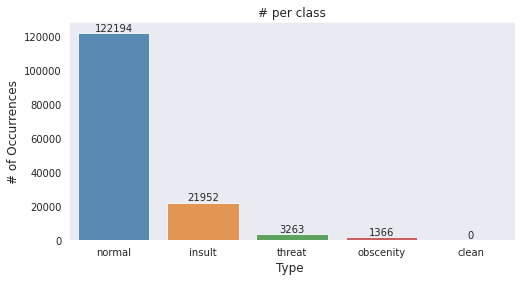

In [ ]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

* Токсичность неравномерно распределена по классам. Следовательно, мы можем столкнуться с проблемами классового дисбаланса
* В наборе данных для обучения содержится ~95 тыс. комментариев, а также ~21 тыс. тегов и ~86 тыс. чистых комментариев!?


## Example Comments:

In [ ]:
print("normal")
print(train[train.normal==1].iloc[2,1])

normal
хоть ногу вверх, ничего не изменится


In [ ]:
print("insult:")
print(train[train.insult==1].iloc[3,1])

insult:
долбаеб . тебе насрать на слезы матери . видать хорошо пилоткой хорошо накрыла тебя


In [ ]:
print("threat:")
print(train[train.threat==1].iloc[5,1])

threat:
такого полицейского убить надо было


In [ ]:
print("obscenity:")
print(train[train.obscenity==1].iloc[4,1])

obscenity:
мигранты выебет тебе


Это была целая куча токсичности. Некоторые странные наблюдения:

* Некоторые комментарии являются исключительно и просто копипастом одного и того же
* Комментарии все еще могут содержать IP-адреса(например:62.158.73.165), имена пользователей(например:ARKJEDI10) и некоторые загадочные номера(я предполагаю, что это идентификаторы статей).

Пункт 2 может привести к огромному переобучению.

# # Облака слов - Частые слова:

Теперь давайте взглянем на слова, которые связаны с этими классами.

Описание диаграммы: Визуальные эффекты здесь-это облака слов (т. Е.), более частые слова кажутся больше. Классный способ создания облаков слов с помощью фанковых фрагментов приведен [здесь](https://www.kaggle.com/arthur взял/жуткий-учебник по нлп и тематическому моделированию). Это включает в себя следующие шаги.
* Поиск изображения и его базовой кодировки 64
* Вставьте кодировку в ячейку и преобразуйте ее с помощью пакета кодеков в изображение
* Создайте облако слов с новым изображением в качестве маски
Более простым способом было бы создать новый набор данных kaggle и импортировать оттуда изображения.

In [ ]:
!ls ../input/imagesforkernal/
stopword=set(STOPWORDS)

ls: cannot access '../input/imagesforkernal/': No such file or directory


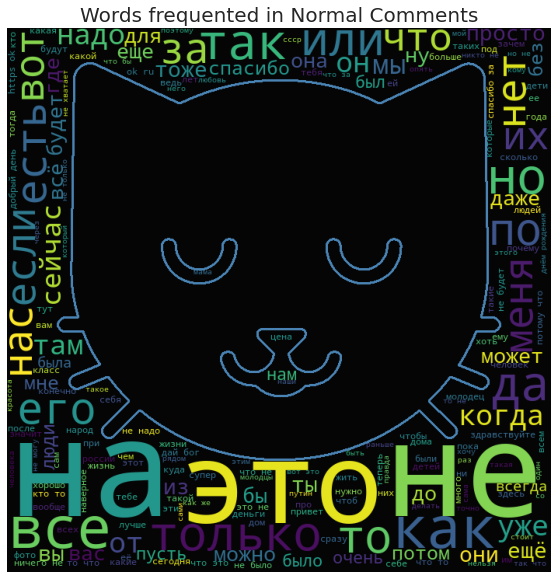

In [ ]:
#normal comments
normal_mask=np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/DF/Bad_comment/Relax Cat.png"))
#wordcloud for normal comments
subset=train[train.normal==True]
text=subset.comment.values
wc= WordCloud(background_color="black",max_words=200,mask=normal_mask,stopwords=stopword, contour_width=3, contour_color='steelblue')
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Normal Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

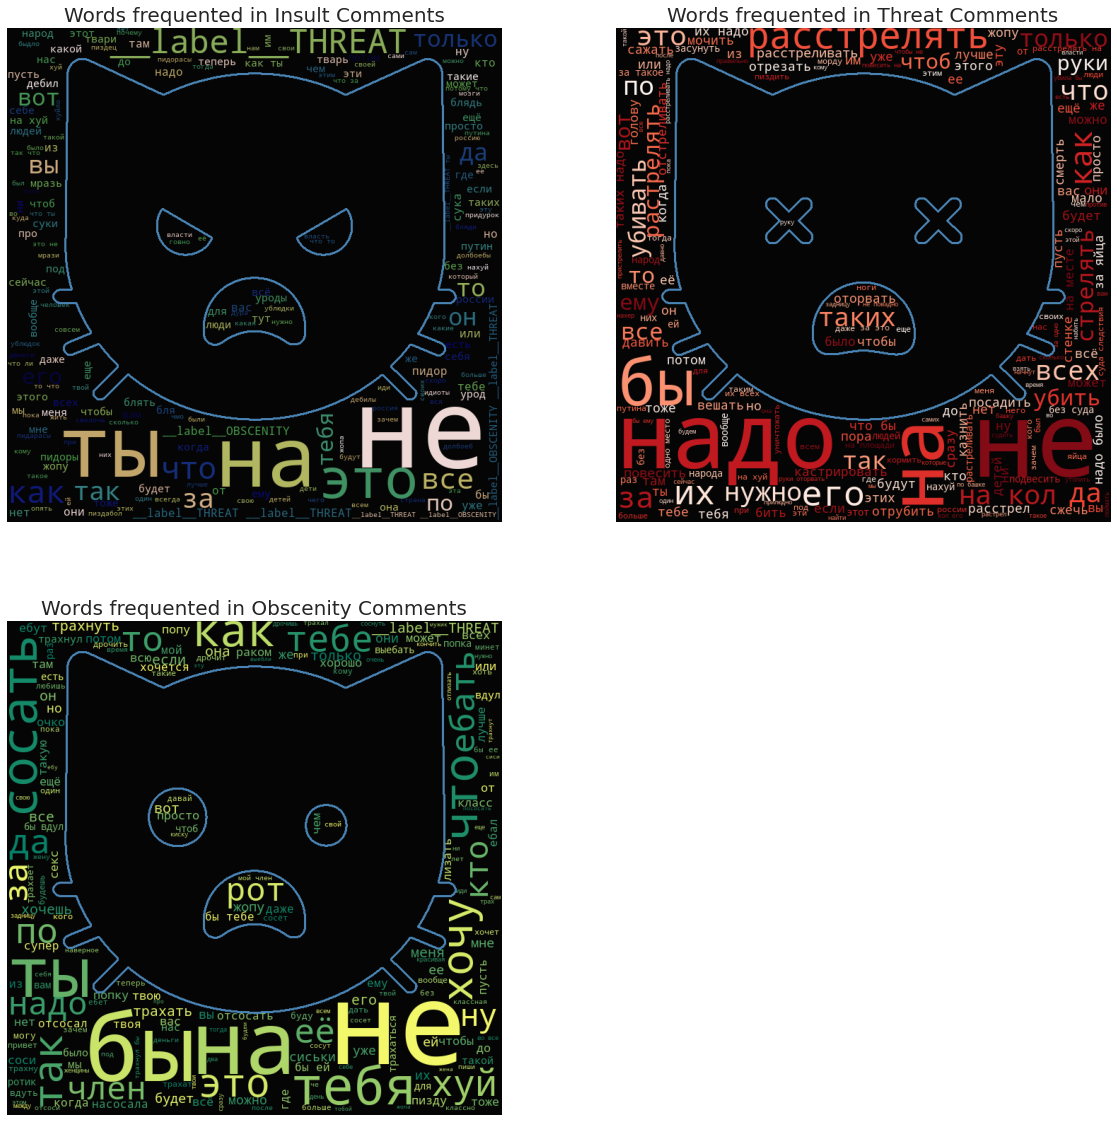

In [ ]:
#Insult comments
insult_mask=np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/DF/Bad_comment/Hungry cat.png"))
insult_mask=insult_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.insult==1]
text=subset.comment.values
wc= WordCloud(background_color="black",max_words=200,mask=insult_mask,stopwords=stopword, contour_width=3, contour_color='steelblue')
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(222)
threat_mask=np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/DF/Bad_comment/Dead Cat.png"))
threat_mask=threat_mask[:,:,1]
subset=train[train.threat==1]
text=subset.comment.values
wc= WordCloud(background_color="black",max_words=200,mask=threat_mask,stopwords=stopword, contour_width=3, contour_color='steelblue')
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threat Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Obscenity comments
plt.subplot(223)
obscenity_mask=np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/DF/Bad_comment/Freak Cat.png"))
obscenity_mask=obscenity_mask[:,:,1]
subset=train[train.obscenity==1]
text=subset.comment.values
wc= WordCloud(background_color="black",max_words=200,mask=obscenity_mask,stopwords=stopword, contour_width=3, contour_color='steelblue')
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Obscenity Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=244), alpha=0.98)



В изображении insult и obscenity видим артефакты а именно ' __ label __THREAT ' изучи их внимательней

In [ ]:
train[train.insult==1].comment.value_counts()

__label__THREAT                                                                                               3747
__label__OBSCENITY                                                                                            1198
мразь! ...какая же мразь....                                                                                     1
остановите эту гниду!!!!!! совсем с катушек съехал!!!!!! под трибунал пора этого плешивого ублюдка!!!!!!!!       1
на фуре респект. чмо обочечное в ад                                                                              1
                                                                                                              ... 
хуйня он а не патриарх                                                                                           1
точна я не верил но кагда машина пакупал акажетса 5раз пидарас!!!!!!!                                            1
усрусь но не покорюсь. таких долбоебов полно на дороге                          

In [ ]:
train[train.obscenity==1].comment.value_counts()

__label__THREAT                                                                                                                                                                          43
вые....ут :d                                                                                                                                                                              1
ебать😱😱😱                                                                                                                                                                                  1
с годами у обезьяны зад станет больше и дырка шире и шире....                                                                                                                             1
сиськи делай, а то по животу плескаются, всю печень отобъют, а хде жить собираешься?чем заниматься?ты гуру орального секса, ехай в пустыню к бедуинам, там и верблюдов много если чё.     1
                                                            

Проверим отсальные комментарии на артифакты

In [ ]:
train[train.normal==1].comment.value_counts()

​на украине такая же кучка начинала митинговать, потом перехватили кому надо и вот результат. поинтересуйтесь и как там жизнь стала кто митинговал и орал.                                                                                                      1
привет я тебя очень хочу можно                                                                                                                                                                                                                                  1
всезнающий закленатель птиц                                                                                                                                                                                                                                     1
вот в том то и дело,вот кто то спрашивает,а почему он газизов в спартак и фомина не продал,хотя по моему мнению это была бы более удачная покупка,чем эта,а зачем, на фомина был покупатель и он его купил,а вот ли были желающие 

In [ ]:
train[train.threat==1].comment.value_counts()

пора расстреливать!                                                                                                                                                                                     1
а ракетами не проще в него пострелять?                                                                                                                                                                  1
растрелять нехер                                                                                                                                                                                        1
лучше пристрелить! решать проблему надо быстро! ато уволить? волокита.                                                                                                                                  1
в заднице тепло , отрубить ему и сразу обе руки, пусть хрюкает...!(fr)                                                                                                                          

In [ ]:
train.sample(5)

,id,comment,normal,insult,threat,obscenity,clean
109545,105853,"восстановили, но не до конца, ещё метра на три...",1,0,0,0,False
21655,60755,"батюшка сказал: , послушание - это одно. подчи...",1,0,0,0,False
55662,187806,при чем здесь пожилые люди? придумали эту фраз...,1,0,0,0,False
96720,122257,хочу лизат трахать мммм,0,0,0,1,False
84590,187498,а в глазах все тот же мальчишеский задор и жел...,1,0,0,0,False


Отлично! 
мы нашли дефекты в коментариях.

Всего девиантных коментариев:

    Insilt - 4945
    Obscenity - 43    
Я вижу два пути решения удаления этих строк и замена на аналогичные коментарии.

По скольку данных не так много процент девиантных коментариев может быть велик, проверим.


In [ ]:
4945 / train[train.insult==1].comment.count() *100

22.526421282798832

In [ ]:
# проверяем количество коментариев
print(train[train.comment=='__label__OBSCENITY'].shape)
print(train[train.comment=='__label__THREAT'].shape)

(1198, 7)
(3790, 7)


 22.5 процента относительно  много.

Принимаю решение заменить данные коментарии.



In [ ]:
train.comment.value_counts()

__label__THREAT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  3790
__label__OBSCENITY                                                                                                                                                                                                                                                                                                                                                                                                                                                                               1198
о, кастрюлеголовые выползли(

In [ ]:
from random import choice

In [ ]:
drop__label__OBSCENITY =train[train.comment=='__label__OBSCENITY']
drop__label__THREAT =train[train.comment=='__label__THREAT']

In [ ]:
comment_clean= train.drop(drop__label__THREAT.index, axis=0)
comment_clean= comment_clean.drop(drop__label__OBSCENITY.index, axis=0)

In [ ]:
list_comment_clean_insult = comment_clean[comment_clean.insult==1].comment.tolist()

In [ ]:
comment_clean[comment_clean.insult==1].comment.value_counts()

это им, блядям не стариков да студенток метелить.                                                                                                                                                                                                   1
съебись отсюда, чурка                                                                                                                                                                                                                               1
ну ты лелька и дурааааа! о какой стабильности ты толдычеш !? ты в какой дыре живёшь ? я вот когда читаю что пишут такие как ты , сразу вопрос возникает что они курят, или может быть колют? страна практически разграблена, а у нее все заебись    1
его бы самого в банку. пока шары не закатит. и никаких судо ненадо. это же маньяк долбаеб. потом не дай бог и людей в такой же упаковке находить станут                                                                                             1
велком это вообщ

In [ ]:
# не смог найти более изящного способа нежели цикл.есть куда рости)
x=0
while x<148775:
  if train.comment[x] == '__label__THREAT':
    train.comment[x] = choice(list_comment_clean_insult)
  x+=1

In [ ]:
i=0
while i<148775:
  if train.comment[i] == '__label__OBSCENITY':
    train.comment[i] = choice(list_comment_clean_insult)
  i+=1

In [ ]:
# проверяем успешность удаления коментариев
print(train[train.comment=='__label__OBSCENITY'].shape)
print(train[train.comment=='__label__THREAT'].shape)

(0, 7)
(0, 7)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148775 entries, 0 to 148774
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         148775 non-null  int64 
 1   comment    148775 non-null  object
 2   normal     148775 non-null  int64 
 3   insult     148775 non-null  int64 
 4   threat     148775 non-null  int64 
 5   obscenity  148775 non-null  int64 
 6   clean      148775 non-null  bool  
dtypes: bool(1), int64(5), object(1)
memory usage: 7.0+ MB


In [ ]:
train.head()

,id,comment,normal,insult,threat,obscenity,clean
0,41127,дворника надо тоже уничтожить!,0,0,1,0,False
1,6812,"моя старшая неделю шипела, не принимала подкид...",1,0,0,0,False
2,6256,полностью с вами согласна!,1,0,0,0,False
3,189636,"хоть ногу вверх, ничего не изменится",1,0,0,0,False
4,99053,а что значит - левого ребенка?,1,0,0,0,False




```
# Выбран кодовый формат
```

# Feature engineering:
I've broadly classified my feature engineering ideas into the following three groups
## Direct features:
Features which are a directly due to words/content.We would be exploring the following techniques
* Word frequency features
    * Count features
    * Bigrams
    * Trigrams
* Vector distance mapping of words (Eg: Word2Vec)
* Sentiment scores

## Indirect features:
Some more experimental features.
* count of sentences 
* count of words
* count of unique words
* count of letters 
* count of punctuations
* count of uppercase words/letters
* count of stop words
* Avg length of each word

## Leaky features:
From the example, we know that the comments contain identifier information (eg: IP, username,etc.).
We can create features out of them but, it will certainly lead to **overfitting** to this specific Wikipedia use-case.
* toxic IP scores
* toxic users

**Note:** 
Creating the indirect and leaky features first. There are two reasons for this,
* Count features(Direct features) are useful only if they are created from a clean corpus
* Also the indirect features help compensate for the loss of information when cleaning the dataset


In [ ]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [ ]:
df.sample(5)

,id,comment
57101,229597,батьку в президенты союза россии и белоруссии!
314851,132316,молодцы таких мразей надо уничтожать
78131,12785,вот уж пизда так пизда! всем пиздам влагалище!
341630,64444,а мы так обрабатывали плодовые деревья от цвет...
344635,241220,"да, конечно, только в сравнении с другими каки..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397065 entries, 0 to 397064
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       397065 non-null  int64 
 1   comment  397065 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.1+ MB


In [ ]:
## Indirect features

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#Number of stopwords
df["count_stopwords"] = df["comment"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [ ]:
#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]


In [ ]:
train_feats

,id,comment,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,41127,дворника надо тоже уничтожить!,1,4,4,30,1,2,6.750000,100.000000,25.000000
1,6812,"моя старшая неделю шипела, не принимала подкид...",1,28,28,195,8,7,6.000000,100.000000,28.571429
2,6256,полностью с вами согласна!,1,4,4,26,1,1,5.750000,100.000000,25.000000
3,189636,"хоть ногу вверх, ничего не изменится",1,6,6,36,1,3,5.166667,100.000000,16.666667
4,99053,а что значит - левого ребенка?,1,6,6,30,2,2,4.166667,100.000000,33.333333
...,...,...,...,...,...,...,...,...,...,...,...
148770,99767,"а вы думаете что полиция об этом не знает, про...",1,42,40,235,7,18,4.619048,95.238095,16.666667
148771,87456,"ну а что вы тут возмущаетесь , все ведь точно ...",1,14,13,58,3,8,3.214286,92.857143,21.428571
148772,185614,затерли до дыр данный ролик сколько лет ему уж...,1,19,19,107,1,7,4.684211,100.000000,5.263158
148773,86412,если проследят за пидором то накажут,1,6,6,36,0,3,5.166667,100.000000,0.000000


In [ ]:
train_tags

,normal,insult,threat,obscenity,clean
0,0,0,1,0,False
1,1,0,0,0,False
2,1,0,0,0,False
3,1,0,0,0,False
4,1,0,0,0,False
...,...,...,...,...,...
148770,1,0,0,0,False
148771,1,0,0,0,False
148772,1,0,0,0,False
148773,0,1,0,0,False


In [ ]:
train_feats=pd.concat([train_feats,train_tags],axis=1)

In [ ]:
pd.concat([train_feats,train_tags],axis=1)

,id,comment,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len,word_unique_percent,punct_percent,normal,insult,threat,obscenity,clean,normal,insult,threat,obscenity,clean
0,41127,дворника надо тоже уничтожить!,1,4,4,30,1,2,6.750000,100.000000,25.000000,0,0,1,0,False,0,0,1,0,False
1,6812,"моя старшая неделю шипела, не принимала подкид...",1,28,28,195,8,7,6.000000,100.000000,28.571429,1,0,0,0,False,1,0,0,0,False
2,6256,полностью с вами согласна!,1,4,4,26,1,1,5.750000,100.000000,25.000000,1,0,0,0,False,1,0,0,0,False
3,189636,"хоть ногу вверх, ничего не изменится",1,6,6,36,1,3,5.166667,100.000000,16.666667,1,0,0,0,False,1,0,0,0,False
4,99053,а что значит - левого ребенка?,1,6,6,30,2,2,4.166667,100.000000,33.333333,1,0,0,0,False,1,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148770,99767,"а вы думаете что полиция об этом не знает, про...",1,42,40,235,7,18,4.619048,95.238095,16.666667,1,0,0,0,False,1,0,0,0,False
148771,87456,"ну а что вы тут возмущаетесь , все ведь точно ...",1,14,13,58,3,8,3.214286,92.857143,21.428571,1,0,0,0,False,1,0,0,0,False
148772,185614,затерли до дыр данный ролик сколько лет ему уж...,1,19,19,107,1,7,4.684211,100.000000,5.263158,1,0,0,0,False,1,0,0,0,False
148773,86412,если проследят за пидором то накажут,1,6,6,36,0,3,5.166667,100.000000,0.000000,0,1,0,0,False,0,1,0,0,False


In [ ]:
train_feats

,id,comment,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len,word_unique_percent,punct_percent,normal,insult,threat,obscenity,clean
0,41127,дворника надо тоже уничтожить!,1,4,4,30,1,2,6.750000,100.000000,25.000000,0,0,1,0,False
1,6812,"моя старшая неделю шипела, не принимала подкид...",1,28,28,195,8,7,6.000000,100.000000,28.571429,1,0,0,0,False
2,6256,полностью с вами согласна!,1,4,4,26,1,1,5.750000,100.000000,25.000000,1,0,0,0,False
3,189636,"хоть ногу вверх, ничего не изменится",1,6,6,36,1,3,5.166667,100.000000,16.666667,1,0,0,0,False
4,99053,а что значит - левого ребенка?,1,6,6,30,2,2,4.166667,100.000000,33.333333,1,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148770,99767,"а вы думаете что полиция об этом не знает, про...",1,42,40,235,7,18,4.619048,95.238095,16.666667,1,0,0,0,False
148771,87456,"ну а что вы тут возмущаетесь , все ведь точно ...",1,14,13,58,3,8,3.214286,92.857143,21.428571,1,0,0,0,False
148772,185614,затерли до дыр данный ролик сколько лет ему уж...,1,19,19,107,1,7,4.684211,100.000000,5.263158,1,0,0,0,False
148773,86412,если проследят за пидором то накажут,1,6,6,36,0,3,5.166667,100.000000,0.000000,0,1,0,0,False


In [ ]:
train_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148775 entries, 0 to 148774
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   148775 non-null  int64  
 1   comment              148775 non-null  object 
 2   count_sent           148775 non-null  int64  
 3   count_word           148775 non-null  int64  
 4   count_unique_word    148775 non-null  int64  
 5   count_letters        148775 non-null  int64  
 6   count_punctuations   148775 non-null  int64  
 7   count_stopwords      148775 non-null  int64  
 8   mean_word_len        148775 non-null  float64
 9   word_unique_percent  148775 non-null  float64
 10  punct_percent        148775 non-null  float64
 11  normal               148775 non-null  int64  
 12  insult               148775 non-null  int64  
 13  threat               148775 non-null  int64  
 14  obscenity            148775 non-null  int64  
 15  clean            

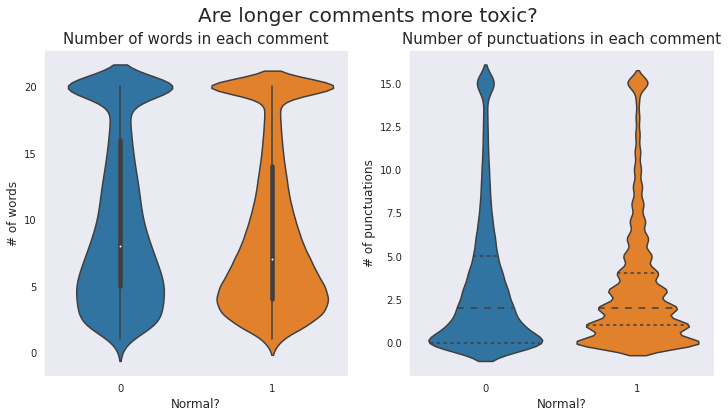

In [ ]:
train_feats['count_word'].loc[train_feats['count_word']>20] = 20 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_word',x='normal', data=train_feats,split=True)
plt.xlabel('Normal?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)
# words
train_feats['count_punctuations'].loc[train_feats['count_punctuations']>15] = 15
plt.subplot(122)
sns.violinplot(y='count_punctuations',x='normal', data=train_feats,split=True,inner="quart")
plt.xlabel('Normal?', fontsize=12)
plt.ylabel('# of punctuations', fontsize=12)
plt.title("Number of punctuations in each comment", fontsize=15)

plt.show()

Long sentences or more words do not seem to be a significant indicator of toxicity.

Chart desc: Violin plot is an alternative to the traditional box plot. The inner markings show the percentiles while the width of the "violin" shows the volume of comments at that level/instance.

In [ ]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='normal')
#spammers - comments with less than 30% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]

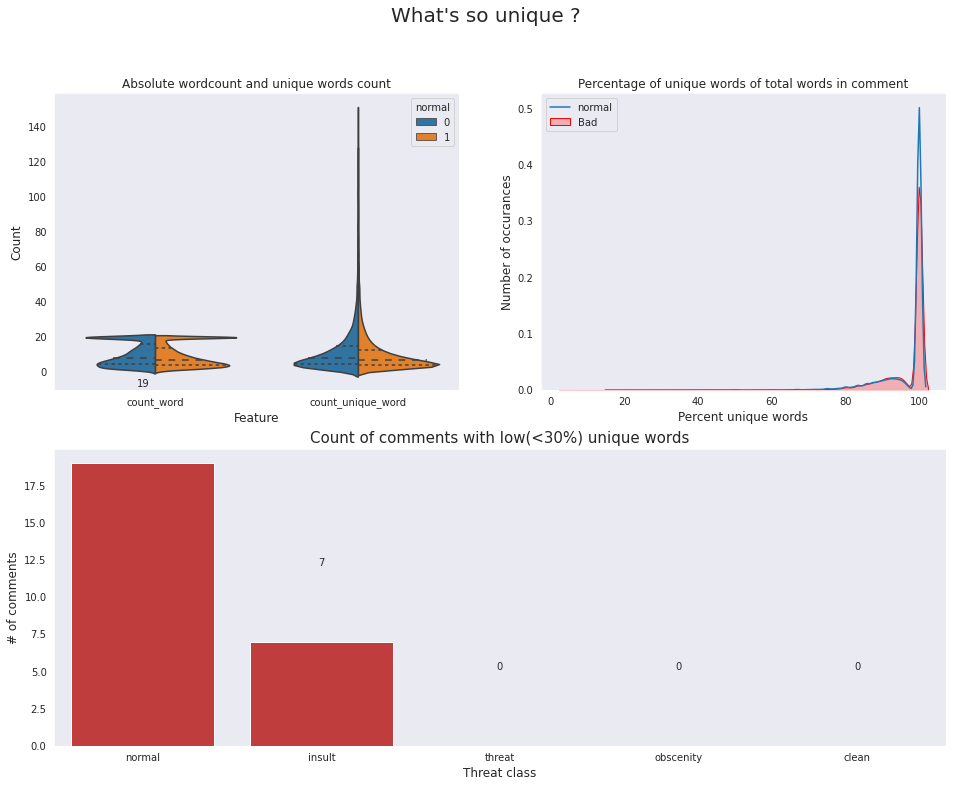

In [ ]:
plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='normal', data=temp_df,split=True,inner='quartile')
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='normal', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.normal == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.normal == 1].word_unique_percent, label="normal")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

x=spammers.iloc[:,-5:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()

### Word count VS unique word count:
There are noticeable shifts in the mean of both word count and unique word count across clean and toxic comments.
   * Chart desc: The first chart is a split violin chart. It is a variation of the traditional box chart/violin chart which allows us to split the violin in the middle based on a categorical variable.
   
### Unique word count percent:
There is a bulge near the 0-10% mark which indicates a large number of toxic comments which contain very little variety of words.
   * Chart desc: The second chart is an overlay of two kernel density estimation plots of percentage of unique words out of all the words in the comment, done for both clean and toxic comments

Even though the number of clean comments dominates the dataset(~90%), there are only 75 clean comments that are spam, which makes it a powerful indicator of a toxic comment.
# Spammers are more toxic!
No surprises here. Let's take a look at some clean and toxic spam messages

In [ ]:
print("Normal Spam example:")
print(spammers[spammers.normal==1].comment.iloc[6])
print("Insult Spam example:")
print(spammers[spammers.insult==1].comment.iloc[3])

Normal Spam example:
поздравпяем!!!!! 🌹 🌹 🌹 🌹 🌹 🌹 🌹
Insult Spam example:
императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура императрица ебнутая дура


# Spam is toxic to the model too!

These spam entries are bad if we design our model to contain normal word counts features.
Imagine the scenario in which our model picked up the words "mitt romney" from any comment and classified it as toxic :(


# Baseline Model:

In [ ]:
#Credis to AlexSanchez https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline-eda-0-052-lb#261316
#custom NB model

class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self
    
# model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)


In [ ]:
SELECTED_COLS=['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_stopwords', 
       'mean_word_len', 'word_unique_percent', 'punct_percent']
target_x=train_feats[SELECTED_COLS]
# target_x

TARGET_COLS=['insult', 'threat', 'obscenity']
target_y=train_tags[TARGET_COLS]

# Strat k fold due to imbalanced classes
# split = StratifiedKFold(n_splits=2, random_state=1)

#https://www.kaggle.com/yekenot/toxic-regression

In [ ]:
target_x

,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,1,4,4,30,1,2,6.750000,100.000000,25.000000
1,1,20,28,195,8,7,6.000000,100.000000,28.571429
2,1,4,4,26,1,1,5.750000,100.000000,25.000000
3,1,6,6,36,1,3,5.166667,100.000000,16.666667
4,1,6,6,30,2,2,4.166667,100.000000,33.333333
...,...,...,...,...,...,...,...,...,...
148770,1,20,40,235,7,18,4.619048,95.238095,16.666667
148771,1,14,13,58,3,8,3.214286,92.857143,21.428571
148772,1,19,19,107,1,7,4.684211,100.000000,5.263158
148773,1,6,6,36,0,3,5.166667,100.000000,0.000000


In [ ]:
target_y

,insult,threat,obscenity
0,0,1,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
148770,0,0,0
148771,0,0,0
148772,0,0,0
148773,1,0,0


In [ ]:
#Just the indirect features -- meta features
print("Using only Indirect features")
model = LogisticRegression(C=3)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
importance=[]
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    importance.append(model.coef_)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))

end_time=time.time()
print("total time till Indirect feat model",end_time-start_time)

Using only Indirect features


In [ ]:
importance[0][0]

In [ ]:
plt.figure(figsize=(16,22))
plt.suptitle("Feature importance for indirect features",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplots_adjust(hspace=0.4)
plt.subplot2grid((3,2),(0,0))
sns.barplot(SELECTED_COLS,importance[0][0],color=color[0])
plt.title("class : Toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(SELECTED_COLS,importance[1][0],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(1,0))
sns.barplot(SELECTED_COLS,importance[2][0],color=color[2])
plt.title("class : Obscene",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)



plt.subplot2grid((3,2),(1,1))
sns.barplot(SELECTED_COLS,importance[3][0],color=color[3])
plt.title("class : Threat",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(SELECTED_COLS,importance[4][0],color=color[4])
plt.title("class : Insult",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(SELECTED_COLS,importance[5][0],color=color[5])
plt.title("class : Identity hate",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


# plt.subplot2grid((4,2),(3,0),colspan=2)
# sns.barplot(SELECTED_COLS,importance[6][0],color=color[0])
# plt.title("class : Clean",fontsize=15)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
# plt.xlabel('Feature', fontsize=12)
# plt.ylabel('Importance', fontsize=12)

plt.show()

In [ ]:
from scipy.sparse import csr_matrix, hstack

#Using all direct features
print("Using all features except leaky ones")
target_x = hstack((train_bigrams,train_charngrams,train_unigrams,train_feats[SELECTED_COLS])).tocsr()


end_time=time.time()
print("total time till Sparse mat creation",end_time-start_time)

In [ ]:
model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
preds_train = np.zeros((X_train.shape[0], len(y_train)))
preds_valid = np.zeros((X_valid.shape[0], len(y_valid)))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))


end_time=time.time()
print("total time till NB base model creation",end_time-start_time)

## Topic modeling:
Due to kernal limitations(kernal timeout at 3600s), I had to continue the exploration in a seperate kernal( [Understanding the "Topic" of toxicity](https://www.kaggle.com/jagangupta/understanding-the-topic-of-toxicity)) to aviod a timeout. 
# Next steps:
* Add Glove vector features
* Explore sentiement scores
* Add LSTM, LGBM

## To be continued

In [ ]:
start_time=time.time()
#importing the dataset
train=pd.read_csv("../input/train.csv")
test=pd.read_csv("../input/test.csv")
end_import=time.time()
print("Time till import:",end_import-start_time,"s"

In [ ]:
#to seperate sentenses into words
def preprocess(comment):
    """
    Function to build tokenized texts from input comment
    """
    return gensim.utils.simple_preprocess(comment, deacc=True, min_len=3)

In [ ]:
#tokenize the comments
train_text=train.comment_text.apply(lambda x: preprocess(x))
test_text=test.comment_text.apply(lambda x: preprocess(x))
all_text=train_text.append(test_text)
end_preprocess=time.time()
print("Time till pre-process:",end_preprocess-start_time,"s")

In [ ]:
#checks
print("Total number of comments:",len(all_text))
print("Before preprocessing:",train.comment_text.iloc[30])
print("After preprocessing:",all_text.iloc[30])

In [ ]:
#Phrases help us group together bigrams :  new + york --> new_york
bigram = gensim.models.Phrases(all_text)

In [ ]:
#check bigram collation functionality 
bigram[all_text.iloc[30]]

In [ ]:
def clean(word_list):
    """
    Function to clean the pre-processed word lists 
    
    Following transformations will be done
    1) Stop words removal from the nltk stopword list
    2) Bigram collation (Finding common bigrams and grouping them together using gensim.models.phrases)
    3) Lemmatization (Converting word to its root form : babies --> baby ; children --> child)
    """
    #remove stop words
    clean_words = [w for w in word_list if not w in eng_stopwords]
    #collect bigrams
    clean_words = bigram[clean_words]
    #Lemmatize
    clean_words=[lem.lemmatize(word, "v") for word in clean_words]
    return(clean_words)    

In [ ]:
#check clean function
print("Before clean:",all_text.iloc[1])
print("After clean:",clean(all_text.iloc[1]))

In [ ]:
#scale it to all text
all_text=all_text.apply(lambda x:clean(x))
end_clean=time.time()
print("Time till cleaning corpus:",end_clean-start_time,"s")

In [ ]:
#create the dictionary
dictionary = Dictionary(all_text)
print("There are",len(dictionary),"number of words in the final dictionary")

In [ ]:
#convert into lookup tuples within the dictionary using doc2bow
print(dictionary.doc2bow(all_text.iloc[1]))
print("Wordlist from the sentence:",all_text.iloc[1])
#to check
print("Wordlist from the dictionary lookup:", 
  dictionary[21],dictionary[22],dictionary[23],dictionary[24],dictionary[25],dictionary[26],dictionary[27])


In [ ]:
#scale it to all text
corpus = [dictionary.doc2bow(text) for text in all_text]
end_corpus=time.time()
print("Time till corpus creation:",end_clean-start_time,"s")

In [ ]:
#create the LDA model
ldamodel = LdaModel(corpus=corpus, num_topics=15, id2word=dictionary)
end_lda=time.time()
print("Time till LDA model creation:",end_lda-start_time,"s")

In [ ]:
pyLDAvis.enable_notebook()

In [ ]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

In [ ]:
end_viz=time.time()
print("Time till viz:",end_viz-start_time,"s")

Chart Desc:

The above visuals are from the awesome pyLDAviz package which is the python version of R package LDAviz.

The Left side shows the multi-dimensional "word-space" superimposed on two "Principal components" and the relative positions of all the topics.

The size of the circle represents what % of the corpus it contains.

The right side shows the word frequencies within the topic and in the whole corpus.

Clearly, some of the topics show a pattern of toxicity (ie) have a high contribution from toxic words.

Now let's feed these topics into a model.

In [ ]:
#creating the topic probability matrix 
topic_probability_mat = ldamodel[corpus]

In [ ]:
#split it to test and train
train_matrix=topic_probability_mat[:train.shape[0]]
test_matrix=topic_probability_mat[train.shape[0]:]

In [ ]:
del(topic_probability_mat)
del(corpus)
del(all_text)
gc.collect()

In [ ]:
#convert to sparse format (Csr matrix)
train_sparse=gensim.matutils.corpus2csc(train_matrix)
test_sparse=gensim.matutils.corpus2csc(test_matrix)
end_time=time.time()
print("total time till Sparse mat creation",end_time-start_time,"s")

In [ ]:
#custom NB model
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self
    

model = NbSvmClassifier(C=2, dual=True, n_jobs=-1)

In [ ]:
#set the target columns
target_x=train_sparse.transpose()
TARGET_COLS=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target_y=train[TARGET_COLS]

In [ ]:
del(train_sparse)
gc.collect()

In [ ]:
model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)
X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=2018)
train_loss = []
valid_loss = []
preds_train = np.zeros((X_train.shape[0], y_train.shape[1]))
preds_valid = np.zeros((X_valid.shape[0], y_train.shape[1]))
for i, j in enumerate(TARGET_COLS):
    print('Class:= '+j)
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Trainloss=log loss:', train_loss_class)
    print('Validloss=log loss:', valid_loss_class)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise log loss:Train dataset', np.mean(train_loss))
print('mean column-wise log loss:Validation dataset', np.mean(valid_loss))


end_time=time.time()
print("total time till NB base model creation",end_time-start_time)

In [ ]:
#credits
#pyLDAviz
#https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

#to be continued 
#to do next
#paragraph vectors
#https://arxiv.org/abs/1507.07998
#https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb